In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [1]:
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers,Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
import os 

# Loading the data

# Resizing diseased leaf images

In [22]:


image_folder = "images"

output_image_folder = "resized_images"
# Target size for resizing
target_size = (256, 256)

# Loop through all files in the folder
for filename in os.listdir(image_folder)
    image_path = os.path.join(image_folder, filename)
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, target_size)
    cv2.imwrite(os.path.join(output_image_folder, filename), resized_image)
print("Resizing completed!")



Resizing completed!


# Resizing mask images

In [29]:

mask_folder = "masks"
output_mask_folder = "resized_masks"
# Target size for resizing
target_size = (256, 256)

# Loop through all files in the folder
for filename in os.listdir(mask_folder):
    image_path = os.path.join(mask_folder, filename)
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, target_size)
    cv2.imwrite(os.path.join(output_mask_folder, filename), resized_image)
print("Resizing completed!")

Resizing completed!


# Extracting pixel into numpy arrays

In [2]:
def extract_pixel(image_folder):
    images = []
    for filename in os.listdir(image_folder):
          image_path = os.path.join(image_folder, filename)
          image = cv2.imread(image_path)
          image_array = np.array(image)
          images.append(image_array)
    return np.array(images)
          
            

In [3]:
def extract_pixel_gray(image_folder):
    images = []
    for filename in os.listdir(image_folder):
          image_path = os.path.join(image_folder, filename)
          img = Image.open(image_path).convert('L')  # Convert to grayscale
          images.append(np.array(img))
          # image = cv2.imread(image_path)
          # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
          # image_array = np.array(gray_image)
          # images.append(image_array)
    return np.array(images)
          

In [4]:
X_i = extract_pixel('resized_images')
Y_m = extract_pixel_gray('resized_masks')

In [5]:
print(X_i.shape)
print(Y_m.shape)




(588, 256, 256, 3)
(588, 256, 256)


# Splitting the Dataset

In [11]:

X_train,x_,Y_train, y_ = train_test_split(X_i,Y_m,test_size = 0.40, random_state = 1)
X_cv,X_test, Y_cv, Y_test = train_test_split(x_,y_,test_size = 0.50, random_state = 1)


# Normalizing the inputs

In [14]:
X_train = X_train/255
X_cv=X_cv/255
X_test = X_test/255
Y_train = Y_train/255
Y_cv = Y_cv/255
Y_test = Y_test/255


In [16]:
import numpy as np

assert not np.any(np.isnan(X_train)), "Images contain NaN values"
assert not np.any(np.isnan(Y_train)), "Masks contain NaN values"
assert np.max(X_train) <= 1.0 and np.min(X_train) >= 0.0, "Images not normalized properly"
assert np.max(Y_train) <= 1.0 and np.min(Y_train) >= 0.0, "Masks not normalized properly"



# Adding an additional dimension

In [18]:
Y_train = np.expand_dims(Y_train, axis=-1)
Y_cv = np.expand_dims(Y_cv, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)

In [20]:
print("Training set:",np.shape(X_train), np.shape(Y_train))
print("Cross-validation set:", np.shape(X_cv), np.shape(Y_cv))
print("Test set:", np.shape(X_test), np.shape(Y_test))

Training set: (352, 256, 256, 3) (352, 256, 256, 1)
Cross-validation set: (118, 256, 256, 3) (118, 256, 256, 1)
Test set: (118, 256, 256, 3) (118, 256, 256, 1)


In [22]:


def unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Contracting Path
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder: Expanding Path
    u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model




In [24]:
model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 32)      │           9,248 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 32)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 64)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 128)       │         147,584 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 128)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 256)       │         590,080 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 64, 64, 128)       │         131,200 │ conv2d_7[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 64, 64, 256)       │               0 │ conv2d_transpose[0][0],    │
│                               │                           │                 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 128)       │         295,040 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())


In [28]:
def weighted_binary_crossentropy(y_true, y_pred, weight):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(weight * y_true * bce + (1 - weight) * (1 - y_true) * bce)


In [30]:
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


In [32]:
model.compile(loss = combined_loss, optimizer = tf.keras.optimizers.Adam(learning_rate=0.01))
model.fit(X_train,Y_train,batch_size=4,epochs = 10)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 90s 931ms/step - loss: 1.1878
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - loss: 1.0609
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 1.0499
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 1.0667
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - loss: 1.0551
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - loss: 1.0493
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - loss: 1.0478
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - loss: 1.0375
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - loss: 1.0348
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - loss: 1.0492


# Evaluation

In [47]:
model = load_model('my_model.keras')

In [242]:
loss = model.evaluate(X_cv,Y_cv)
print(loss)


4/4 ━━━━━━━━━━━━━━━━━━━━ 56s 12s/step - loss: 1.0780
1.0833333730697632


# Making predictions

In [111]:
def make_predictions(X):
    prediction = model.predict(X)
    threshold = 0.05
    yhat = (prediction > threshold).astype(np.uint8)
    return yhat

# Computing error

In [113]:
def compute_error(yhat, y):
      correct_predictions = tf.equal(yhat, y)
      accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
      error = 1-accuracy

      return error.numpy()

# Training Error

In [123]:
y= make_predictions(X_train)
error = compute_error(y,Y_train)
print(error)

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
0.19805199


# Cross validation Error

In [125]:
y= make_predictions(X_cv)
error = compute_error(y,Y_cv)
print(error)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.16482335


# Test Error

In [127]:
y= make_predictions(X_test)
error = compute_error(y,Y_test)
print(error)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.19295323


# Predictions for the first 10 test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


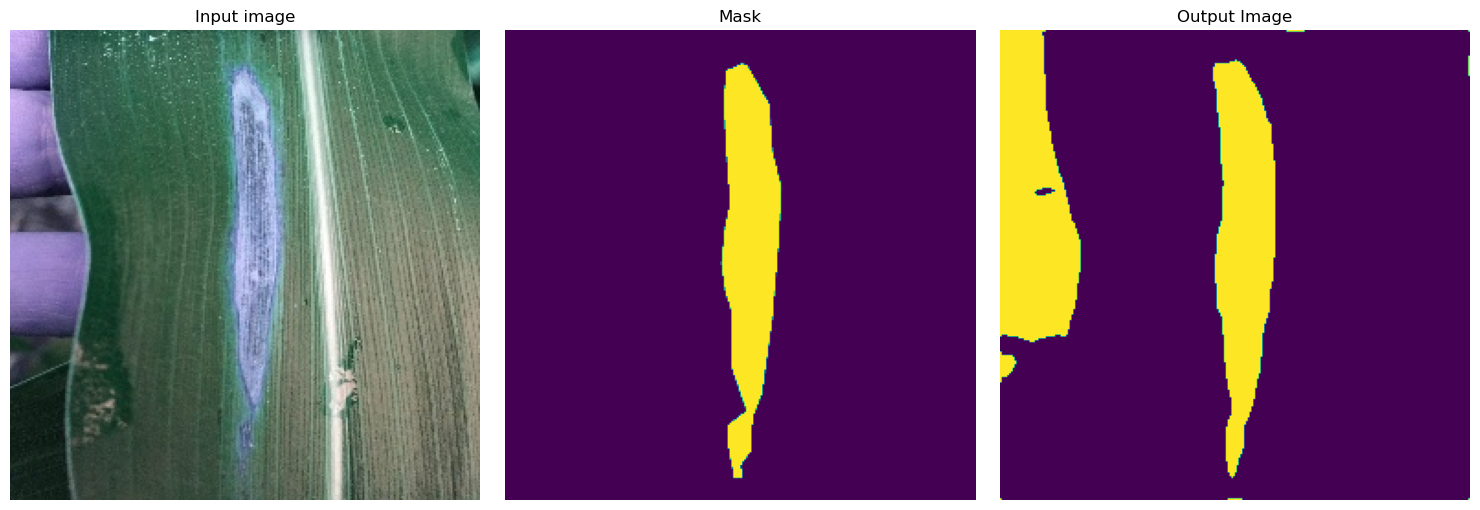

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


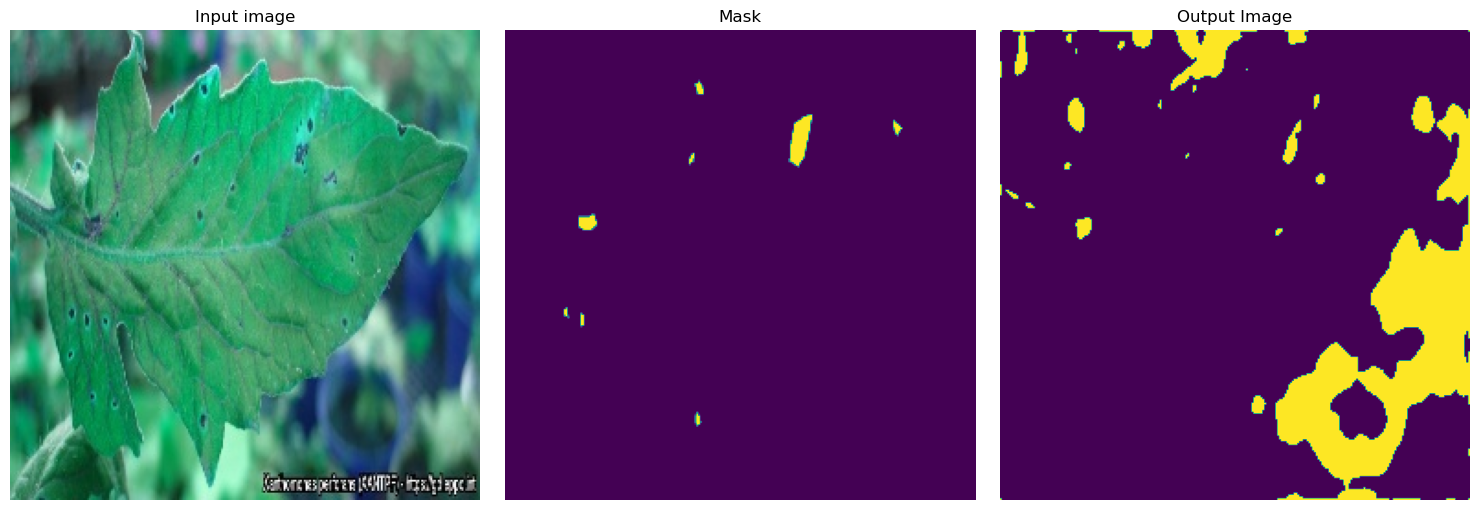

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


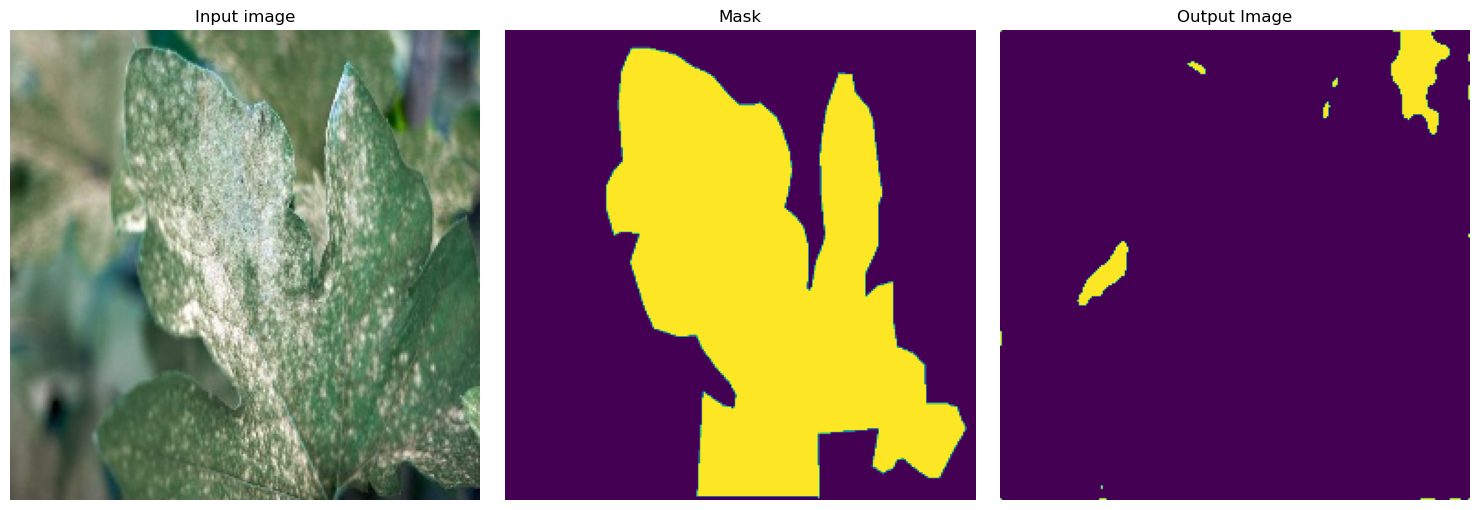

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


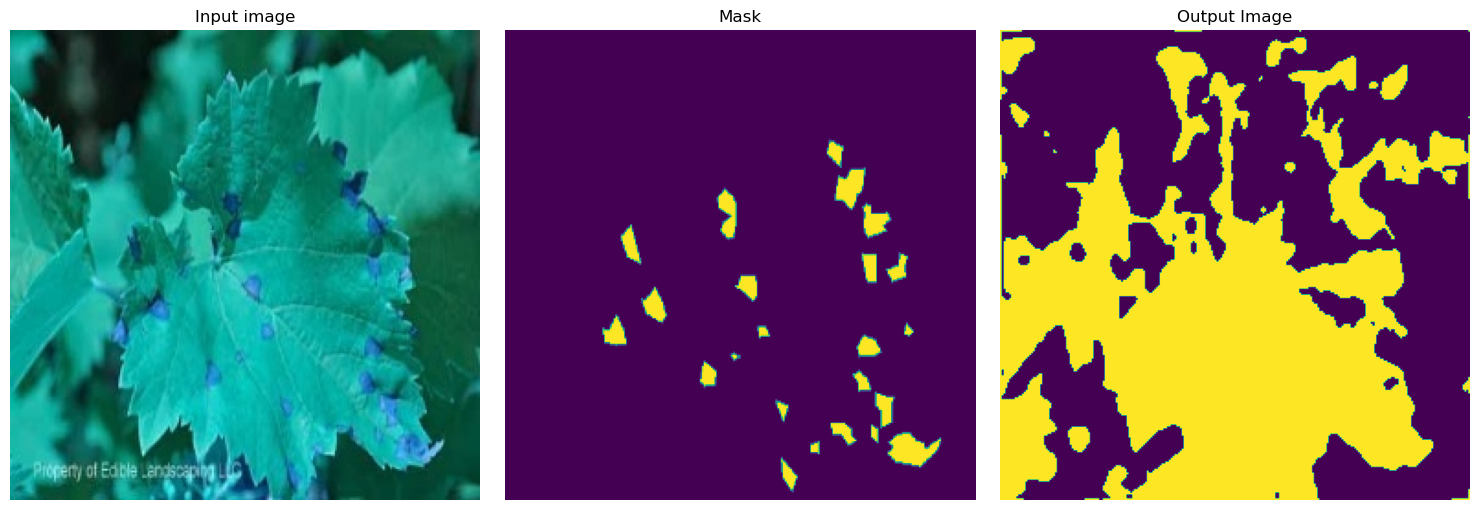

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


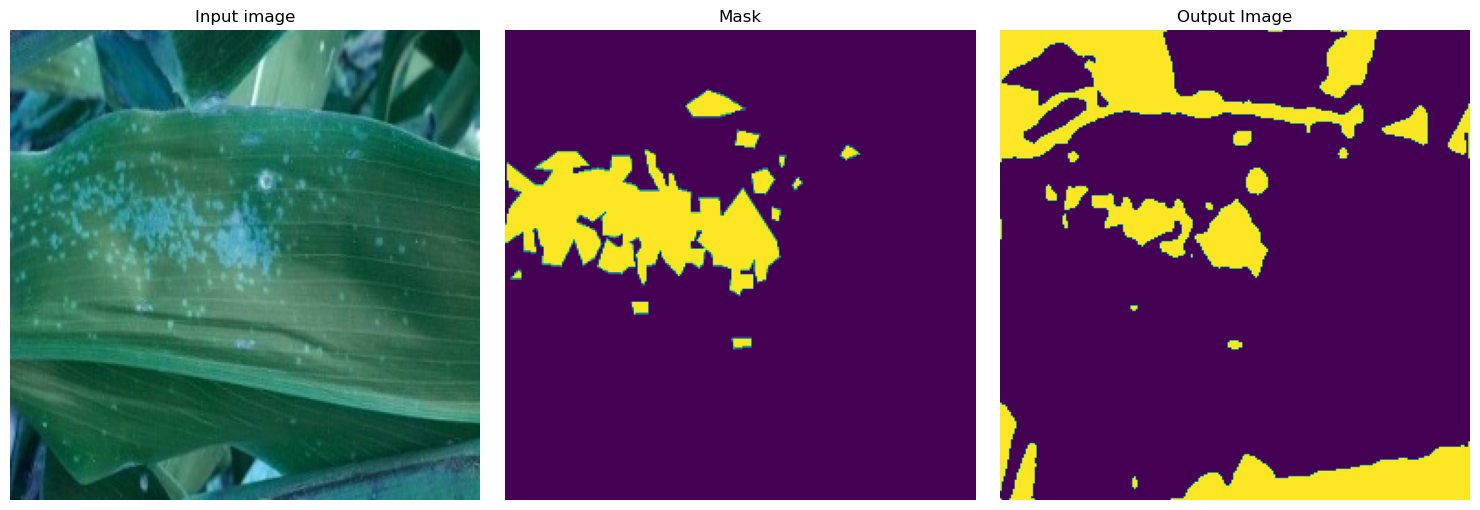

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


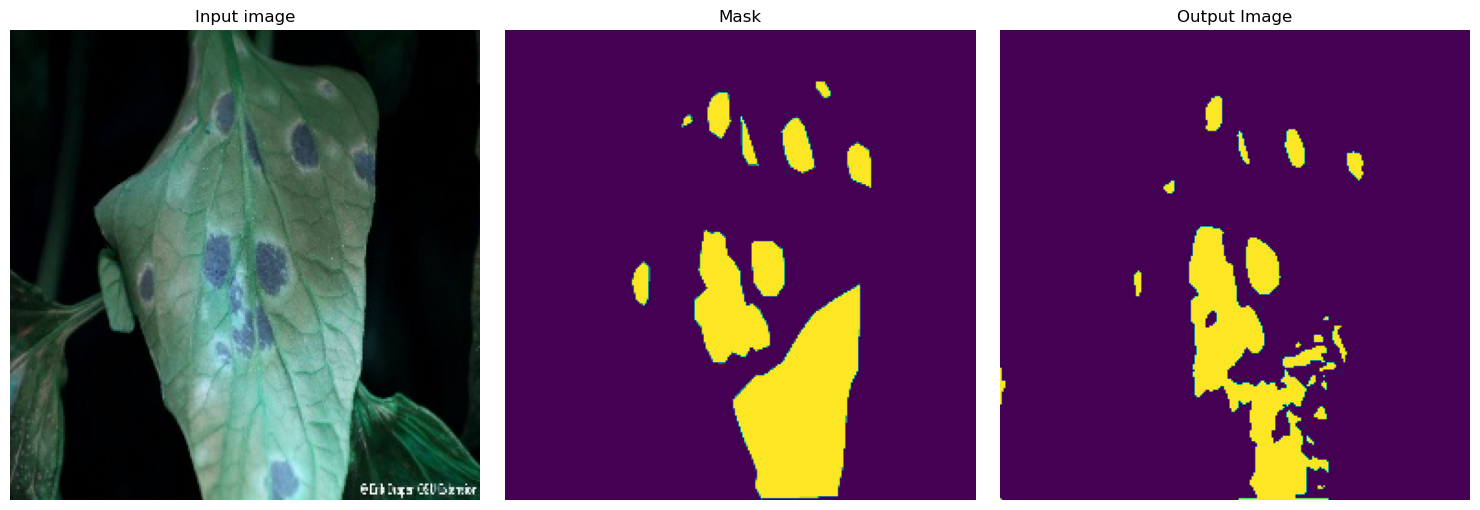

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


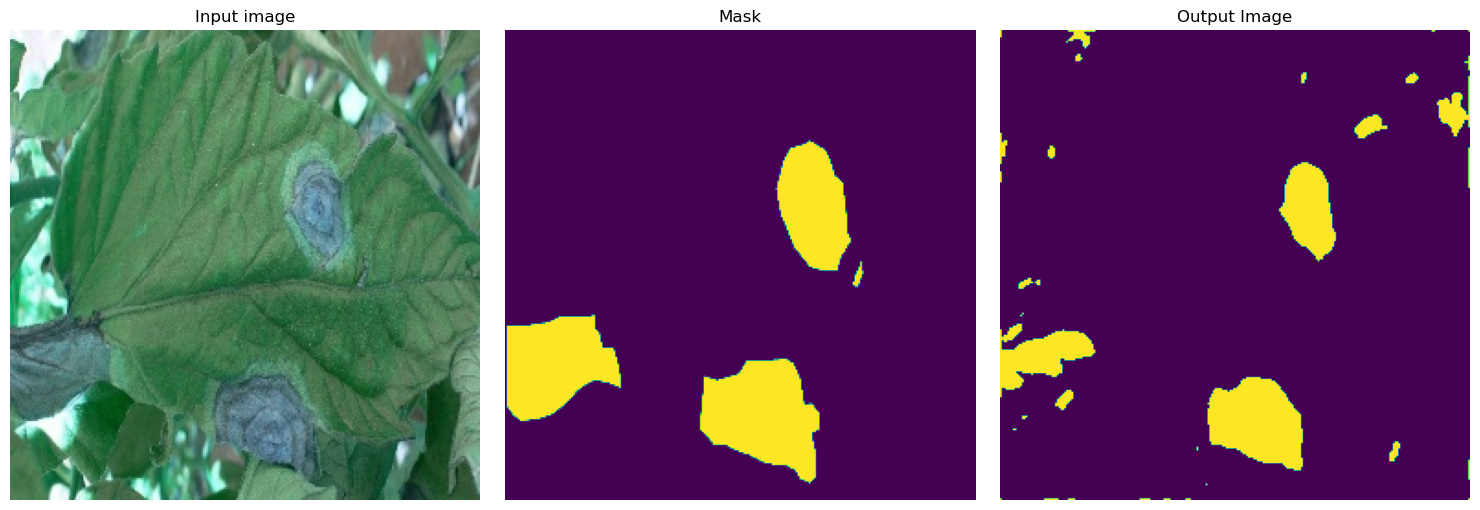

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


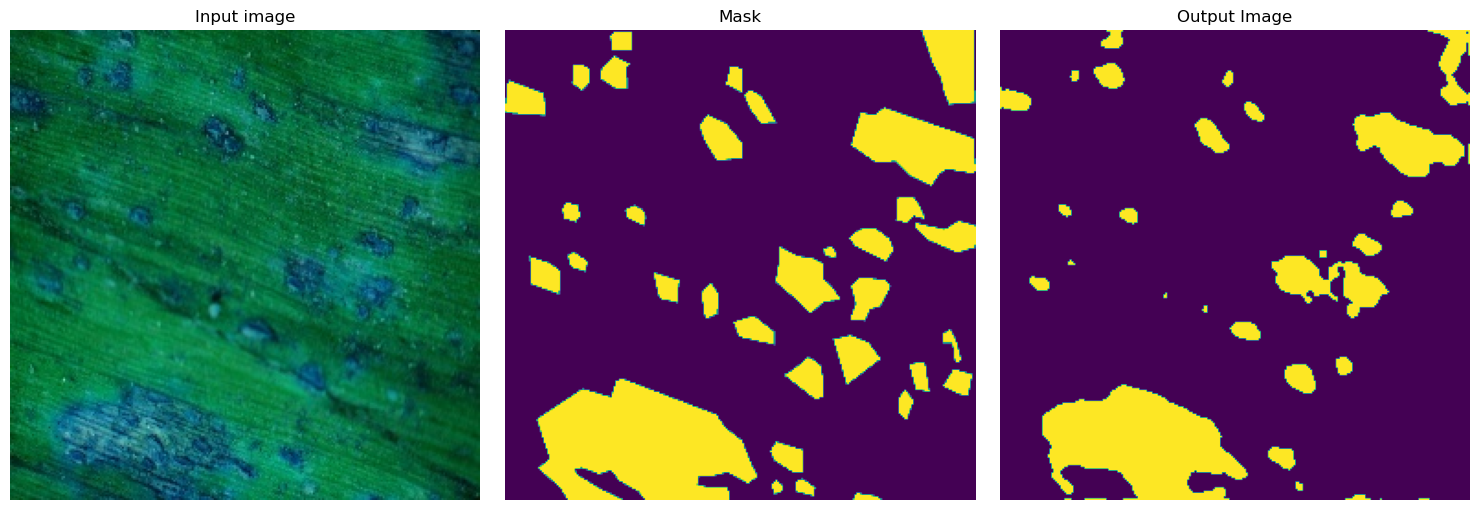

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


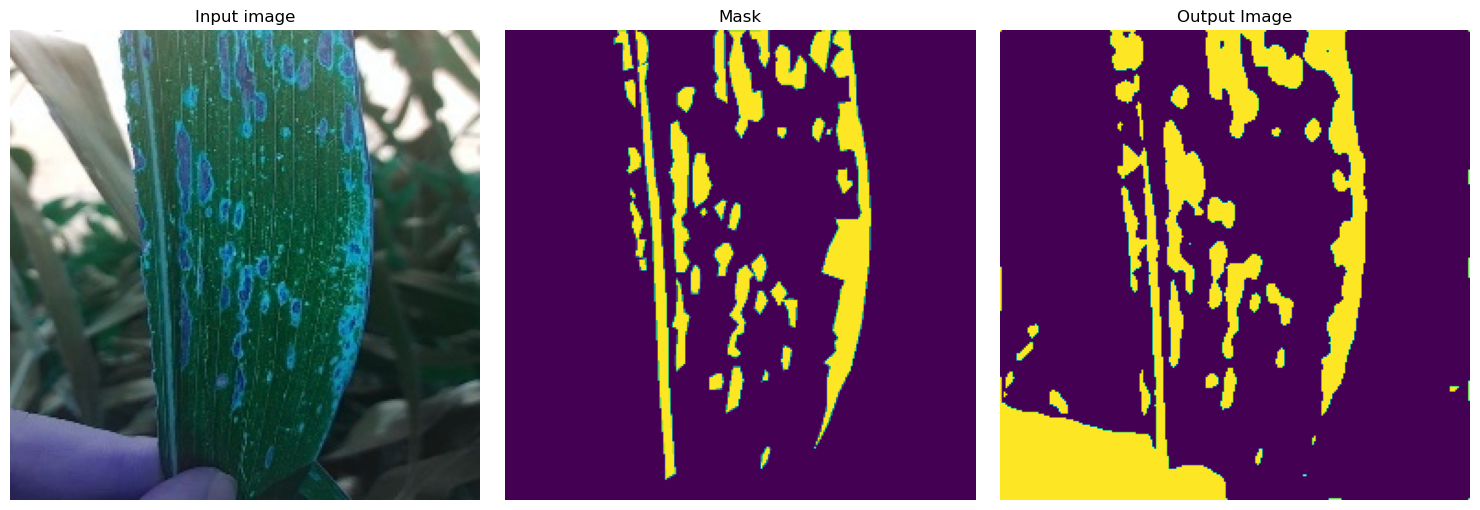

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


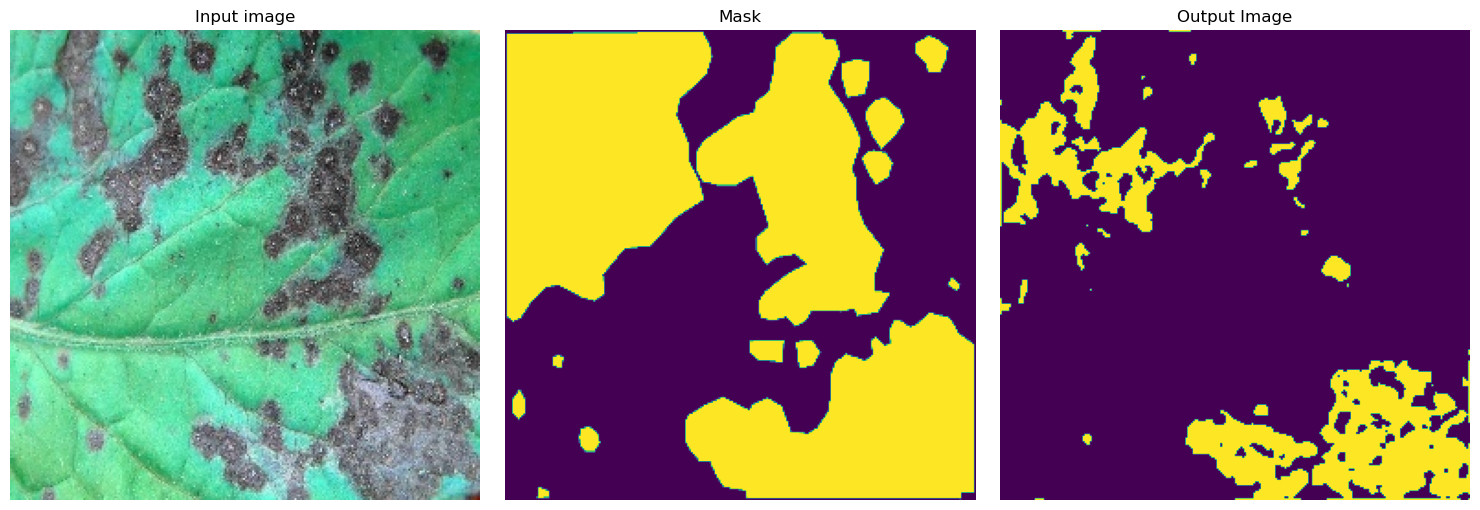

In [133]:
for i in range(10):
   y = make_predictions(np.expand_dims(X_test[i],axis = 0))
  
   y_reduced = np.squeeze(y)#reducing the tensor dimension

   plt.figure(figsize=(15, 5))
   plt.subplot(1, 3, 1) 
   plt.imshow(X_test[i])
   plt.title("Input image")
   plt.axis('off')  

   plt.subplot(1, 3, 2)  
   plt.imshow(Y_test[i])
   plt.title("Mask")
   plt.axis('off')
   plt.subplot(1, 3, 3)  
   plt.imshow(y_reduced)
   plt.title("Output Image")
   plt.axis('off')
   plt.tight_layout()  
   plt.show()
   
